# **Created by Amir-Isfahani**
# Hepatitis Dataset: Exploratory Data Analysis (EDA)


<p>This notebook presents a systematic approach to performing Exploratory Data Analysis (EDA) on the Hepatitis dataset. The objective is to prepare the data for effective training of a Machine Learning (ML) model. The steps outlined below guide the process from initial data inspection to advanced feature engineering.</p>

## **EDA Workflow**:

### 1. **Import Libraries**
   Import essential libraries and packages necessary for data analysis and visualization.

### 2. **Load the Hepatitis Dataset**
   Load the dataset into the environment for further exploration and preparation.

### 3. **Initial Data Examination**
   Conduct a thorough initial examination to understand the dataset’s structure and characteristics.

   #### 3.1. **Dataset Dimensions**
   - `df.shape`: Determine the dataset’s size by reviewing the number of rows and columns.

   #### 3.2. **Data Preview**
   - `df.head()`, `df.tail()`, `df.sample(5)`: Get a preliminary view of the data, examining the first, last, and random entries.

   #### 3.3. **Dataset Information**
   - `df.info()`: Gain insight into data types and the presence of missing values.

   #### 3.4. **Statistical Summary**
   - `df.describe()`: Generate summary statistics for numerical variables.

   #### 3.5. **Feature Selection**
   - `df.select_dtypes(include/exclude="number"/"category")`: Segregate numerical and categorical features for focused analysis.

   #### 3.6. **Feature Relationships**
   - Analyze the relationships between features using Correlation, Mutual Information, and Statistical Tests.

### **Data Preprocessing**

#### A. **Duplicate Detection and Removal**
   - Eliminate any redundant records to ensure the dataset's accuracy.

#### B. **Handling Missing Data**
   - Apply appropriate techniques to manage missing values, whether through imputation or removal.

#### C. **Skewness Correction**
   - Address skewed distributions in numerical features to improve model performance.

#### D. **Outlier Management**
   - Identify and treat outliers to maintain data integrity.

#### E. **Data Filtering**
   - Refine the dataset by applying filters to focus on relevant data subsets.

#### F. **Scaling Numerical Features**
   - Standardize numerical variables to ensure uniformity across features.

#### G. **Encoding Categorical Features**
   - Convert categorical variables into a numerical format suitable for modeling.

#### H. **Feature Engineering**
   - Develop new features to enhance model accuracy and predictive power.

### **Advanced Feature Techniques**

#### 11.1. **Dimensionality Reduction**
   - Utilize PCA, t-SNE, or UMAP to reduce the feature space while retaining essential information.

#### 11.2. **Manual Feature Engineering**
   - Create custom features based on domain knowledge to capture deeper insights.


# import prerequisite

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# function

## 1. function(Make a function for create a Data Frame as df.info *)

In [ ]:
def info_data_frame(data_frame:pd.DataFrame):
    columns=data_frame.columns
    columns=list(columns)
    df_info=pd.DataFrame(data=columns,columns=["Column"])
    not_null=list()
    Dtypes=list()
    Max=list()
    Min=list()
    for column in data_frame.columns:
        not_null.append((~data_frame[column].isna()).sum())
        Dtypes.append(data_frame[column].dtype)
        Max.append(data_frame[column].max())
        Min.append(data_frame[column].min())
    df_info["notNull"]=not_null
    df_info["Dtype"]=Dtypes
    df_info["Max"]=Max
    df_info["Min"]=Min
    return df_info

## 2. function (find null value in each rows)

In [ ]:
def find_isna(data_frame:pd.DataFrame,Condition:int = 0):
    list_isna=list()
    for row_index in range(len(data_frame)-1):
        if data_frame.iloc[row_index].isna().sum()>=Condition:
            list_isna.append(data_frame.iloc[row_index].isna().sum())
    value_data_frame=pd.DataFrame(data=list_isna,columns=["isna"]).reset_index()
    return value_data_frame

## 3. function (visualize numerical)

In [ ]:
def visualize_numerical_distributions(df, exclude_columns='id'):

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numeric_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numeric_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

## 4. function (Skewness handing)


In [ ]:
from scipy import stats

def robust_skewness_handler(df, threshold=2.0):
    transformed_df = df.copy()
    transformation_dict = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        data = df[col].dropna()
        skewness = data.skew()

        if abs(skewness) > threshold:
            print(f"Handling skewness for {col} (skewness: {skewness:.2f})")

            # Handle zero-inflated or near-zero-inflated data
            if (data == 0).sum() / len(data) > 0.1:  # If more than 10% zeros
                non_zero = data[data != 0]
                if len(non_zero) > 0:
                    log_transform = np.log1p(non_zero)
                    transformed_df.loc[data != 0, col] = log_transform
                    transformation_dict[col] = ('log1p', 'zero-inflated')
                    print(f"  Applied Log1p to non-zero values for {col}")
                continue

            # Try Box-Cox transformation
            min_val = data.min()
            if min_val <= 0:
                shift = abs(min_val) + 1
                shifted_data = data + shift
            else:
                shifted_data = data

            try:
                transformed_data, lambda_param = stats.boxcox(shifted_data)
                transformed_df[col] = transformed_data
                transformation_dict[col] = ('box-cox', lambda_param)
                print(f"  Applied Box-Cox to {col} (lambda: {lambda_param:.2f})")
            except:
                # If Box-Cox fails, try other transformations
                if skewness > 0:  # Right-skewed
                    if data.max() / data.min() > 1000:  # Very large range
                        transformed_df[col] = np.log1p(data)
                        transformation_dict[col] = ('log1p', None)
                        print(f"  Applied Log1p to {col}")
                    else:
                        transformed_df[col] = np.sqrt(data)
                        transformation_dict[col] = ('sqrt', None)
                        print(f"  Applied Square Root to {col}")
                else:  # Left-skewed
                    transformed_df[col] = data ** 2
                    transformation_dict[col] = ('square', None)
                    print(f"  Applied Square to {col}")

    return transformed_df, transformation_dict

## 5. function (calculate Outlier)


In [ ]:
def calculate_outliers_percentage(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    # Print the percentage of outliers for each column
    for column in outlier_counts:
        percentage = (outlier_counts[column] / len(df)) * 100
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")

## 6. function (calculate Outlier)

In [ ]:
def handle_outliers(df):
    for column in numeric_cols:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

# hepatitis dataset

## read hepatitis dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/datasets/hepatitis/master/data/hepatitis.csv")

## Basic Exploration

In [ ]:
pd.set_option('display.max_columns', None)
df.head(10)

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live
5,34,female,True,False,False,False,False,True,False,False,False,False,False,0.9,95.0,28.0,4.0,75.0,False,live
6,51,female,False,False,True,False,True,True,False,True,True,False,False,NaN,NaN,NaN,NaN,NaN,False,die
7,23,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,NaN,NaN,NaN,False,live
8,39,female,True,False,True,False,False,True,True,False,False,False,False,0.7,NaN,48.0,4.4,NaN,False,live
9,30,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,120.0,3.9,NaN,False,live


In [ ]:
df.dtypes

In [ ]:
df.tail(10)

In [ ]:
df.columns

In [ ]:
df.sample(10)

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
info_data_frame(df)

In [ ]:
categoory_columns=df.select_dtypes(include=[np.object_,'bool']).columns #name of categorical columns
numeric_columns=df.select_dtypes(include=np.number).columns #name of numeric columns
categoory_columns=categoory_columns.drop(labels=["class"]) #drop target columns
# categoory_columns.tolist().remove('class') #remove class object inplace


## Null handling

In [ ]:
# use the function to find nulls value of each row
# drop 5 rows (These 5 rows have many null values)
nulls=find_isna(df)
nulls=nulls.sort_values("isna")
# df=df.drop(index=nulls.tail(5).index) #[72,41,118,56,147]

In [ ]:
pd.isna(df).sum().sum()

(155, 20)

#### KNN imputer method (numeric)

In [ ]:
knn_imputer=KNNImputer(n_neighbors=3)
df1_imputed=knn_imputer.fit_transform(df[numeric_columns]) #np_array
df[numeric_columns]=pd.DataFrame(df1_imputed,columns=[numeric_columns]) #np_array to Dataframe
# pd.isna(df_numeric).sum().sum() #cheke nulls

### Fix categoory cols

In [ ]:
# categoory
df[categoory_columns] = df[categoory_columns].fillna(df[categoory_columns].mode().iloc[0])
# pd.isna(df[categoory_columns]).sum().sum() #0
df[categoory_columns]

,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology
0,male,False,False,False,False,False,False,False,False,False,False,False,False
1,female,False,False,True,False,False,False,False,False,False,False,False,False
2,female,True,False,True,False,False,True,False,False,False,False,False,False
3,female,True,True,False,False,False,True,False,False,False,False,False,False
4,female,True,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,female,True,False,True,True,True,True,False,False,True,True,True,True
151,female,True,False,True,False,False,True,True,False,False,False,False,True
152,female,False,False,True,True,False,False,True,False,True,False,False,True
153,male,False,False,True,False,False,True,False,True,True,False,True,True


In [ ]:
le=LabelEncoder()
for col in categoory_columns:
  le.fit(df[col])
  df[col]=le.transform(df[col])
le.fit(df["class"])
df["class"]=le.transform(df["class"])

## remove Dublicate

In [ ]:
df.duplicated().sum() #0
df.drop_duplicates()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30.0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,85.000000,18.0,4.0,94.666667,0,1
1,50.0,0,0,0,1,0,0,0,0,0,0,0,0,0.9,135.000000,42.0,3.5,57.000000,0,1
2,78.0,0,1,0,1,0,0,1,0,0,0,0,0,0.7,96.000000,32.0,4.0,58.000000,0,1
3,31.0,0,1,1,0,0,0,1,0,0,0,0,0,0.7,46.000000,52.0,4.0,80.000000,0,1
4,34.0,0,1,0,0,0,0,1,0,0,0,0,0,1.0,123.333333,200.0,4.0,70.333333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46.0,0,1,0,1,1,1,1,0,0,1,1,1,7.6,127.000000,242.0,3.3,50.000000,1,0
151,44.0,0,1,0,1,0,0,1,1,0,0,0,0,0.9,126.000000,142.0,4.3,52.333333,1,1
152,61.0,0,0,0,1,1,0,0,1,0,1,0,0,0.8,75.000000,20.0,4.1,82.666667,1,1
153,53.0,1,0,0,1,0,0,1,0,1,1,0,1,1.5,81.000000,19.0,4.1,48.000000,1,1


### correlation

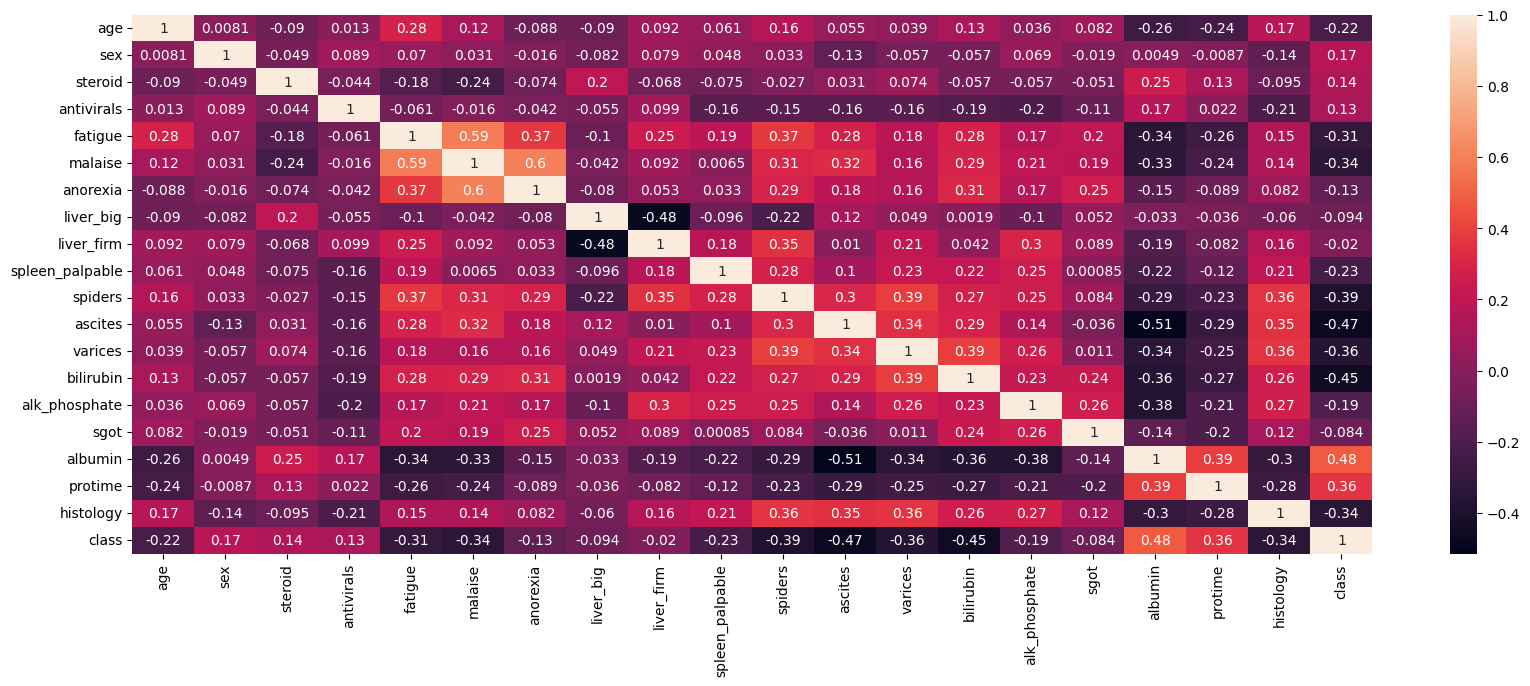

In [ ]:
# df[numeric_columns].corr() #Tabular Show

sns.heatmap(df.corr(), annot = True) #hitmap show
plt.rcParams['figure.figsize'] = (20,7)
plt.show() #error#

### Skewness handing

In [ ]:
df.skew()

,0
age,0.365294
sex,2.633738
steroid,-0.039096
antivirals,1.926980
fatigue,-0.642651
malaise,0.440068
anorexia,1.464700
liver_big,-1.859869
liver_firm,0.468129
spleen_palpable,1.566545


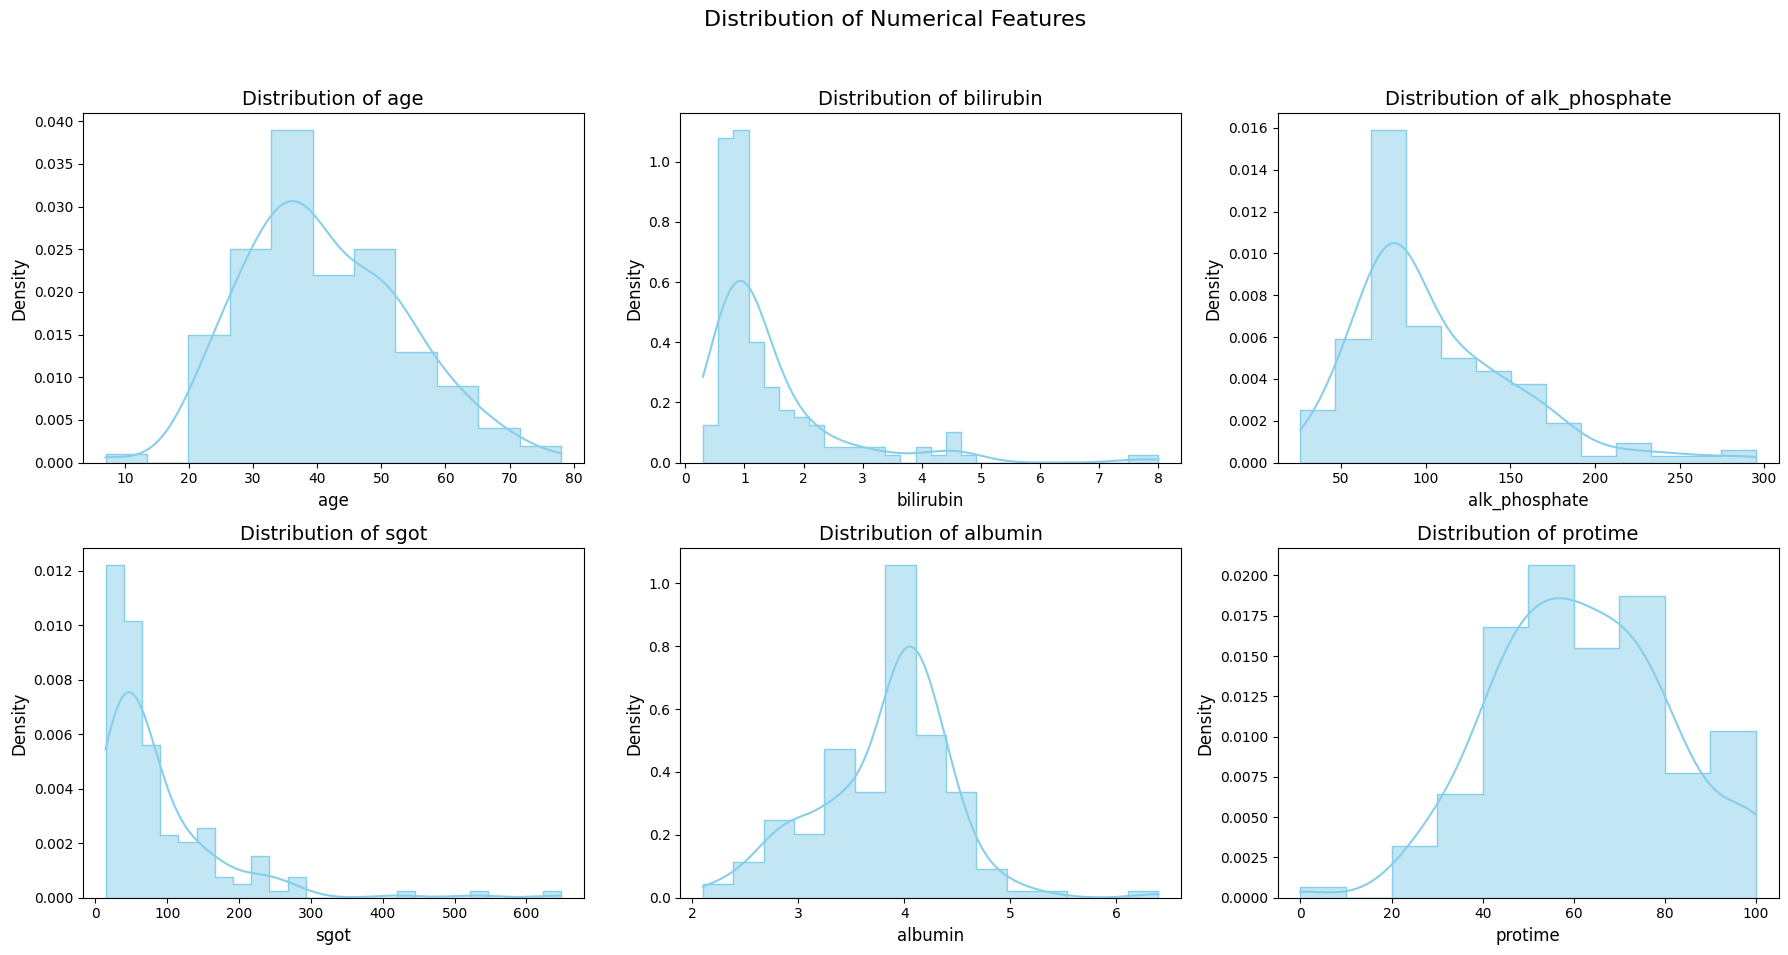

In [ ]:

visualize_numerical_distributions(df)


Handling skewness for bilirubin (skewness: 2.89)
  Applied Square Root to bilirubin
Handling skewness for sgot (skewness: 3.18)
  Applied Square Root to sgot


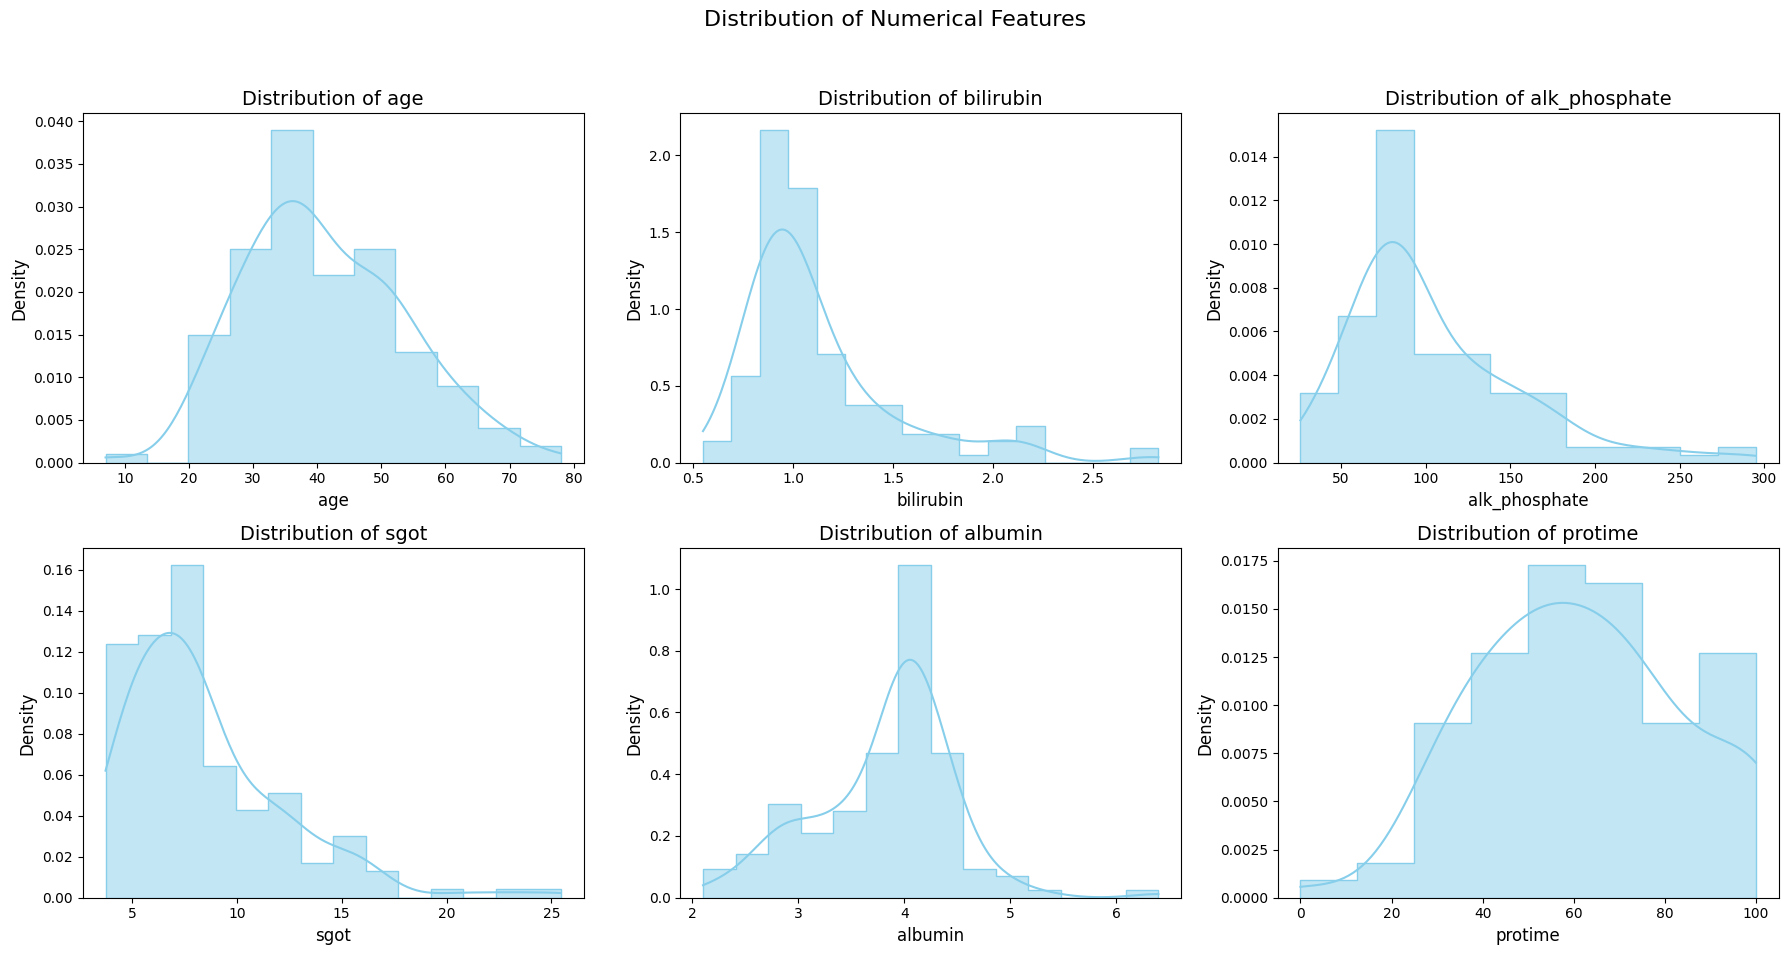

In [ ]:
transformed_df, transformations = robust_skewness_handler(df)
visualize_numerical_distributions(transformed_df)

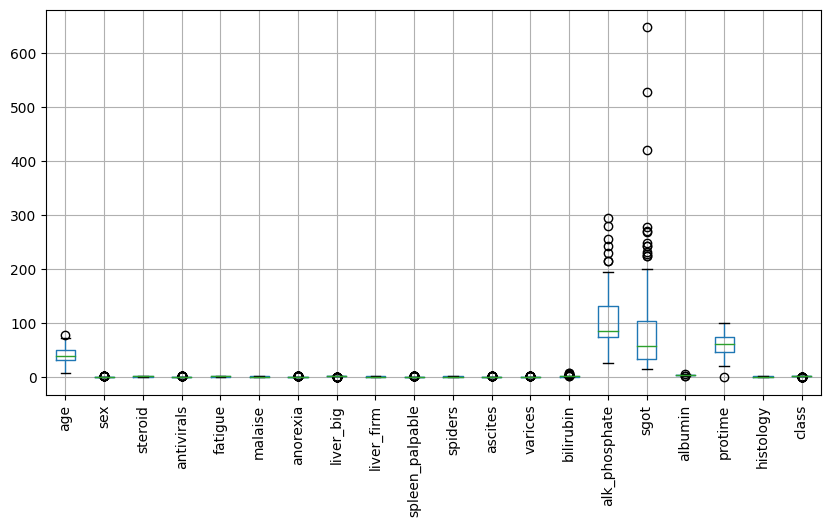

In [ ]:
plt.figure(figsize=(10,5))
df.boxplot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
calculate_outliers_percentage(df)

In [ ]:
df = handle_outliers(df)

In [ ]:
calculate_outliers_percentage(df)